In [2]:
import random
import torch

from utils.Logger import showPlot
from utils.Timer import asMinutes, timeSince

%load_ext autoreload
from data.exampleJP_Data import Lang, prepareData
from model.rnn_model.encoderRNN import EncoderGRU, EncoderLSTM
from model.rnn_model.decoderRNN import (
    DecoderGRU, DecoderLSTM, 
    AttnDecoderGRU, AttnDecoderLSTM1, AttnDecoderLSTM2
)
from model.seq2seq_Model import (
    Seq2Seq_batch_ptModel, 
    Seq2SeqTranslate_ptTokenizer,
)
from baselineJP_ExpTrain import example_ExpTrain
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load data

In [3]:
!mkdir _data_example/
%cd '_data_example'

if True:    # 解凍する場合は True に書き換え
    !git clone https://github.com/odashi/small_parallel_enja
    !echo '------------------'
    !head -n 5 small_parallel_enja/train.en
    !head -n 5 small_parallel_enja/train.ja
    !echo '------------------'
!ls
%cd ../

mkdir: _data_example/: File exists
/Volumes/GoogleDrive/マイドライブ/__datasets__/[CV][NLP]「センター試験xml」/annotate_img/datas/center_exam_2011/construct/Experiment/_data_example
fatal: destination path 'small_parallel_enja' already exists and is not an empty directory.
------------------
i can 't tell who will arrive first .
many animals have been destroyed by men .
i 'm in the tennis club .
emi looks happy .
please bear this fact in mind .
誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。
多く の 動物 が 人間 に よ っ て 滅ぼ さ れ た 。
私 は テニス 部員 で す 。
エミ は 幸せ そう に 見え ま す 。
この 事実 を 心 に 留め て お い て 下さ い 。
------------------
data                data.zip            small_parallel_enja
/Volumes/GoogleDrive/マイドライブ/__datasets__/[CV][NLP]「センター試験xml」/annotate_img/datas/center_exam_2011/construct/Experiment


## setup Experiment

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## setup Data

In [5]:
input_lang, output_lang, pairs = prepareData(
    'en', 'ja', '_data_example/small_parallel_enja', False)

Reading lines...
Read 50000 sentence pairs
Counting words...
Counted words:
en 6637
ja 8777


In [6]:
print(random.choice(pairs))
print(input_lang.n_words, output_lang.n_words)

['i have a bad headache .', 'ひど い 頭痛 が し ま す 。']
6637 8777


In [7]:
# train / test split
from sklearn.model_selection import train_test_split
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2)

## setup Model

In [8]:
## Model
tokenizer = Seq2SeqTranslate_ptTokenizer(
                    input_lang, output_lang, device)

### test

In [9]:
batch_size = 10
emb_size = 8
hid_size = 12
MAX_LENGTH = 18

test_encoder = EncoderLSTM(input_lang.n_words, emb_size, hid_size)
test_decoder1 = AttnDecoderLSTM1(
                    emb_size, hid_size, output_lang.n_words,
                    device, max_length=MAX_LENGTH)
seq2seq_test_model = Seq2Seq_batch_ptModel(
                    tokenizer, device,
                    dropout_p=0.1, max_length=MAX_LENGTH)
seq2seq_test_model.load_enc_dec_models(test_encoder, test_decoder1)
seq2seq_test_model.exec_test(train_pairs, batch_size=batch_size)


[Info] input_batch.shape, input_lens.shape
     =  torch.Size([11, 10]) torch.Size([10])
[Info] enc_outputs.shape, hidden_h.shape, hidden_c.shape
     =  torch.Size([11, 10, 24]) torch.Size([1, 10, 12]) torch.Size([1, 10, 12])
[Info] hidden[0].shape, hidden[1].shape
     =  torch.Size([10, 12]) torch.Size([10, 12])
[Info] dec_outputs.shape, hidden[0].shape, hidden[1].shape, attn_weights.shape
     =  torch.Size([10, 8777]) torch.Size([10, 12]) torch.Size([10, 12]) torch.Size([10, 18])
[Info] loss.item()
     =  9.093545913696289


In [10]:
attn_size = 9

test_decoder2 = AttnDecoderLSTM2(
                    emb_size, hid_size, attn_size, 
                    output_lang.n_words, device).to(device)
seq2seq_test_model.load_enc_dec_models(test_encoder, test_decoder2)
seq2seq_test_model.exec_test(train_pairs, batch_size=batch_size)

[Info] input_batch.shape, input_lens.shape
     =  torch.Size([11, 10]) torch.Size([10])
[Info] enc_outputs.shape, hidden_h.shape, hidden_c.shape
     =  torch.Size([11, 10, 24]) torch.Size([1, 10, 12]) torch.Size([1, 10, 12])
[Info] hidden[0].shape, hidden[1].shape
     =  torch.Size([10, 12]) torch.Size([10, 12])
[Info] dec_outputs.shape, hidden[0].shape, hidden[1].shape, attn_weights.shape
     =  torch.Size([10, 8777]) torch.Size([10, 12]) torch.Size([10, 12]) torch.Size([10, 11])
[Info] loss.item()
     =  9.201638221740723


## setup Model

In [11]:
%load_ext autoreload
from model.rnn_model.decoderRNN import (
    DecoderGRU, DecoderLSTM, 
    AttnDecoderGRU, AttnDecoderLSTM1, AttnDecoderLSTM2
)
from model.seq2seq_Model import (
    Seq2Seq_batch_ptModel, 
    Seq2SeqTranslate_ptTokenizer,
)
from baselineJP_ExpTrain import example_ExpTrain
%autoreload


emb_size = 1024
hidden_size = 1024

seq2seq_model = Seq2Seq_batch_ptModel(
                            tokenizer, device,
                            dropout_p=0.1, max_length=MAX_LENGTH)

encoder = EncoderLSTM(input_lang.n_words, emb_size, hidden_size)
decoder = AttnDecoderLSTM1(emb_size, hidden_size, output_lang.n_words, device)
seq2seq_model.load_enc_dec_models(encoder, decoder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## setup exec

In [12]:
%load_ext autoreload
from baselineJP_ExpTrain import example_ExpTrain
%autoreload

%matplotlib inline

## exec
exp_train = example_ExpTrain(train_pairs, test_pairs, log_dir='_logs')
exp_train.exec(seq2seq_model, 
                epochs=20, batch_size=200, 
                teacher_forcing=0.9, early_stopping=3)

0it [00:00, ?it/s]The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
21it [05:14, 14.95s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-70656b551612>", line 9, in <module>
    exp_train.exec(seq2seq_model,
  File "/Volumes/GoogleDrive/マイドライブ/__datasets__/[CV][NLP]「センター試験xml」/annotate_img/datas/center_exam_2011/construct/Experiment/baselineJP_ExpTrain.py", line 57, in exec
    loss = model.fit_batch(input_batch, input_lens,
  File "/Volumes/GoogleDrive/マイドライブ/__datasets__/[CV][NLP]「センター試験xml」/annotate_img/datas/center_exam_2011/construct/Experiment/model/seq2seq_Model.py", line 170, in fit_batch
    loss.backward()
  File "/Users/m_ryo/.pyenv/ve

TypeError: object of type 'NoneType' has no len()

In [ ]:
# 本実験
# exp_train.exec(seq2seq_model, 75000,
#                 print_every=5000, plot_every=1000, 
#                 learning_rate=0.01, log_dir='_logs')

# emb_size = 1024
# hidden_size = 1024
# attn_size = 1024

# encoder = EncoderRNN(input_lang.n_words, emb_size, hidden_size).to(device)
# decoder = AttnDecoderRNN2(emb_size, hidden_size, attn_size, output_lang.n_words).to(device)
# train_iters(encoder, decoder, batch_size=200, epochs=20, teacher_forcing=0.9, early_stopping=3)

___

## evaluate
- random print
- Acc
- BLEU などの 評価指標

In [17]:
%load_ext autoreload
from baseline_ExpEval import evaluate_batch_randomly
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


> the house is not in very good condition .
= その 家 は あまり い い 状態 で は な い 。
< 彼 は は は に に い 。 <EOS>
bleu: 4.677275655524805e-155



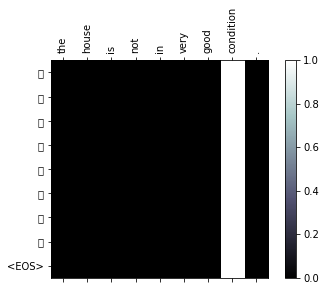

> ken put on his clothes .
= ケン は 服 を 着 た 。
< 私 は は は 。 <EOS>
bleu: 9.711929667259895e-232



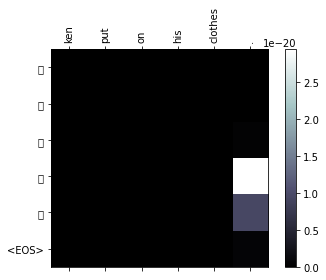

> i am his junior by three years .
= 私 は 彼 より ３ 歳 年下 で す 。
< 私 は は を に い 。 <EOS>
bleu: 5.023587836914362e-155



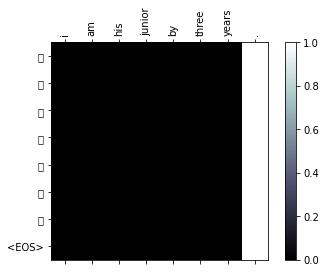

> she is rather poor at tennis .
= 彼女 は かなり テニス が 下手 だ 。
< 私 は は は の に い 。 <EOS>
bleu: 1.2882297539194154e-231

/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/textpath.py:84: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0, flags=flags)


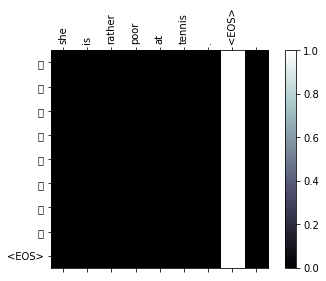

> i feel very sorry for him .
= 私 は 彼 を 大変 気の毒 に 思 っ て い る 。
< 私 は は は を い 。 <EOS>
bleu: 3.718347556444741e-155



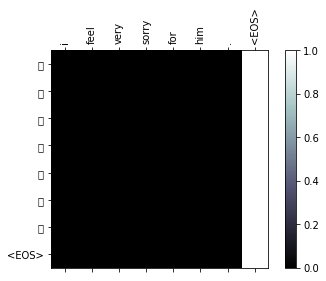

> during hot weather , be sure to drink lots of water .
= 熱 い 夏 の 間 、 たくさん の 水 を 飲 み な さ い 。
< 私 は は の に い 。 <EOS>
bleu: 2.131874265859462e-155



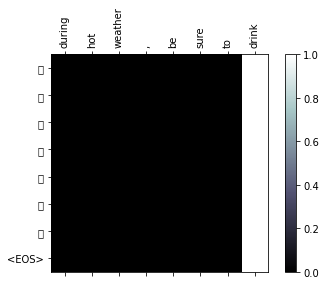

> he avoided the bait .
= 彼 は その 手 に は の ら な かっ た 。
< 彼 は は に 。 <EOS>
bleu: 2.6010274958328437e-155



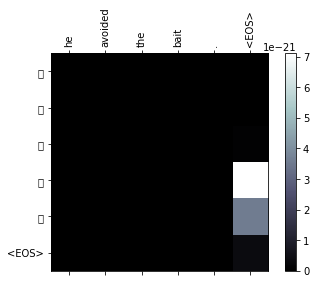

> you must answer honestly .
= あなた は 正直 に 答え な けれ ば な り ま せ ん 。
< 私 は は は 。 <EOS>
bleu: 2.3949323699607068e-232



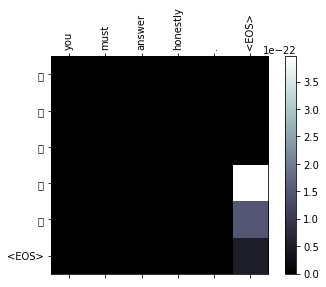

> we have time enough to eat .
= 食事 を する 時間 は たっぷり あ る 。
< 私 は は を は に い 。 <EOS>
bleu: 1.258141043412406e-231



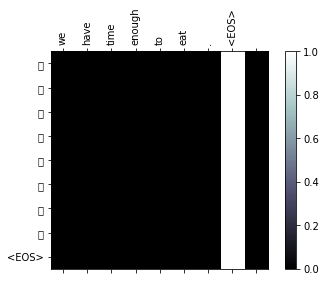

> i like him best of all the teachers .
= 全部 の 先生 の うち で 彼 が 一番 好き だ 。
< 私 は は は を に い 。 <EOS>
bleu: 6.570351225189682e-232



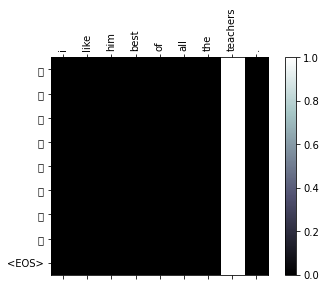

[4.677275655524805e-155,
 9.711929667259895e-232,
 5.023587836914362e-155,
 1.2882297539194154e-231,
 3.718347556444741e-155,
 2.131874265859462e-155,
 2.6010274958328437e-155,
 2.3949323699607068e-232,
 1.258141043412406e-231,
 6.570351225189682e-232]

In [19]:
evaluate_batch_randomly(seq2seq_model, pairs)